In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from torch import nn, optim
import torch
from scipy import stats

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/solarpower.csv')
print(df.shape)  # e.g., (many rows, 21)
print(df.head())
print(df.describe())

(4213, 21)
   temperature_2_m_above_gnd  relative_humidity_2_m_above_gnd  \
0                       2.17                               31   
1                       2.31                               27   
2                       3.65                               33   
3                       5.82                               30   
4                       7.73                               27   

   mean_sea_level_pressure_MSL  total_precipitation_sfc  snowfall_amount_sfc  \
0                       1035.0                      0.0                  0.0   
1                       1035.1                      0.0                  0.0   
2                       1035.4                      0.0                  0.0   
3                       1035.4                      0.0                  0.0   
4                       1034.4                      0.0                  0.0   

   total_cloud_cover_sfc  high_cloud_cover_high_cld_lay  \
0                    0.0                              0   

Series([], dtype: int64)
generated_power_kw                   1.000000
shortwave_radiation_backwards_sfc    0.556148
temperature_2_m_above_gnd            0.217280
mean_sea_level_pressure_MSL          0.150551
snowfall_amount_sfc                 -0.049508
azimuth                             -0.061184
wind_direction_80_m_above_gnd       -0.069941
wind_direction_10_m_above_gnd       -0.073257
wind_direction_900_mb               -0.077435
wind_speed_10_m_above_gnd           -0.083043
wind_speed_900_mb                   -0.107615
total_precipitation_sfc             -0.118442
wind_gust_10_m_above_gnd            -0.122808
high_cloud_cover_high_cld_lay       -0.147723
wind_speed_80_m_above_gnd           -0.157899
medium_cloud_cover_mid_cld_lay      -0.227834
low_cloud_cover_low_cld_lay         -0.288066
total_cloud_cover_sfc               -0.334338
relative_humidity_2_m_above_gnd     -0.336783
angle_of_incidence                  -0.646537
zenith                              -0.649991
Name: gen

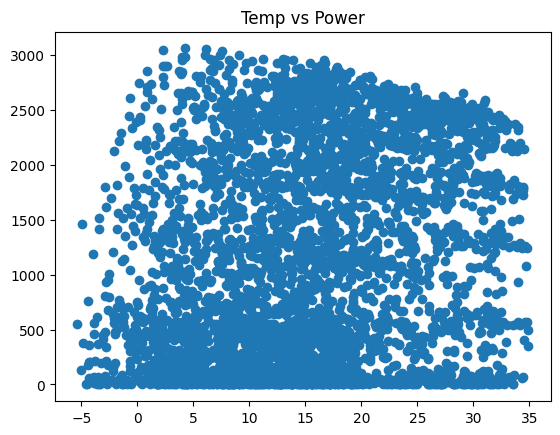

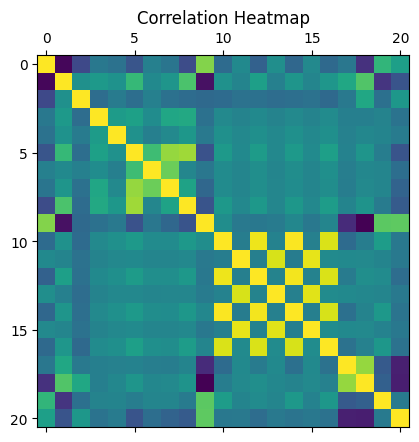

In [3]:
# Step 2: Exploration
# Missing (few, but impute if any)
missing = df.isnull().sum()
print(missing[missing > 0])
# Correlations
corr = df.corr()
print(corr['generated_power_kw'].sort_values(ascending=False))  # Top: shortwave_radiation, temperature, etc.
# Plots
plt.scatter(df['temperature_2_m_above_gnd'], df['generated_power_kw'])
plt.title('Temp vs Power')
plt.show()
plt.matshow(corr)
plt.title('Correlation Heatmap')
plt.show()
# Outliers: Z-score >3
z_scores = np.abs(stats.zscore(df.select_dtypes(include=np.number)))
outliers = (z_scores > 3).any(axis=1)
df = df[~outliers]

In [4]:
# Step 3: Preprocessing
# Impute missing (mean)
df = df.fillna(df.mean(numeric_only=True))
# Select features (top 10 by corr, exclude target)
target_corr = abs(corr['generated_power_kw']).sort_values(ascending=False)[1:11]
selected_cols = target_corr.index.tolist()
X = df[selected_cols]
y = df['generated_power_kw']

In [5]:
# Step 4: Split (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

                            OLS Regression Results                            
Dep. Variable:     generated_power_kw   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     649.0
Date:                Fri, 30 Jan 2026   Prob (F-statistic):               0.00
Time:                        07:13:28   Log-Likelihood:                -24807.
No. Observations:                3215   AIC:                         4.964e+04
Df Residuals:                    3204   BIC:                         4.970e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

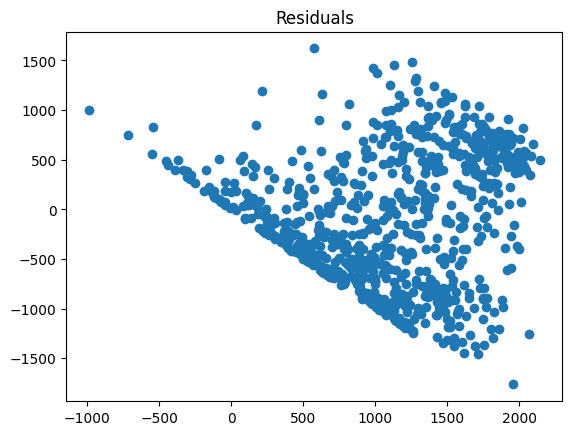

In [6]:
X_train_sm = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train_sm).fit()
print(model_ols.summary())  # R², coeffs

# Predictions/Eval
X_test_sm = sm.add_constant(X_test)
y_pred_ols = model_ols.predict(X_test_sm)
mae_ols = np.mean(np.abs(y_test - y_pred_ols))
rmse_ols = np.sqrt(np.mean((y_test - y_pred_ols)**2))
r2_ols = 1 - np.sum((y_test - y_pred_ols)**2) / np.sum((y_test - np.mean(y_test))**2)
print(f'OLS MAE: {mae_ols}, RMSE: {rmse_ols}, R2: {r2_ols}')

# Residual Plot
plt.scatter(y_pred_ols, y_test - y_pred_ols)
plt.title('Residuals')
plt.show()

Epoch 0, Loss: 2197520.5
Epoch 10, Loss: 848335.25
Epoch 20, Loss: 777638.8125
Epoch 30, Loss: 647963.9375
Epoch 40, Loss: 566955.375
Epoch 50, Loss: 540860.1875
Epoch 60, Loss: 531218.8125
Epoch 70, Loss: 520206.65625
Epoch 80, Loss: 507683.59375
Epoch 90, Loss: 494770.09375
NN MAE: 674.266943056483, RMSE: 803.0140147155948, R2: 0.21824037787874606


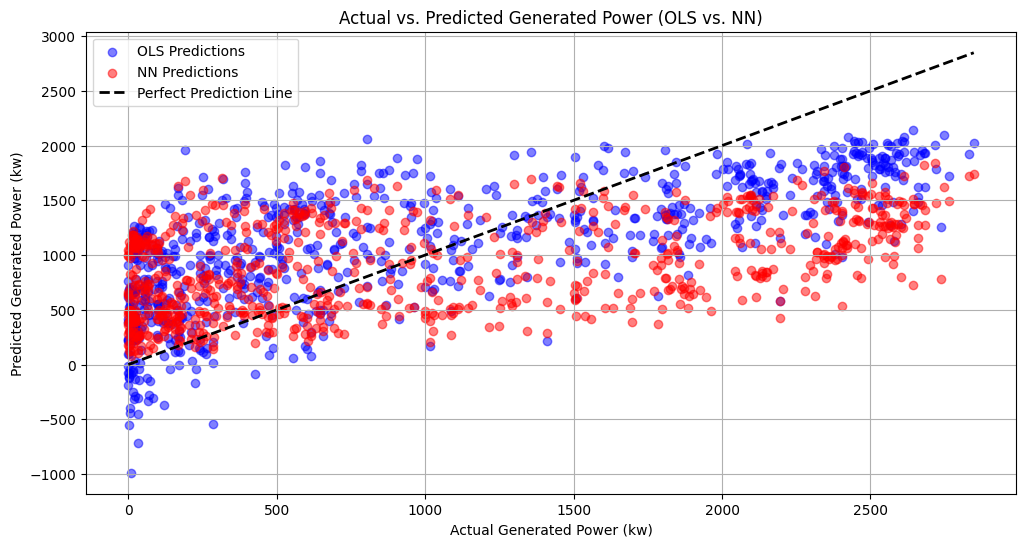

In [10]:
# Step 6: Model 2 - Advanced: Simple NN with Torch
class SimpleNNReg(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
model_nn = SimpleNNReg(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.01)

# Train
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model_nn(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Eval
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_pred_nn = model_nn(X_test_t).detach().numpy().flatten()
mae_nn = np.mean(np.abs(y_test - y_pred_nn))
rmse_nn = np.sqrt(np.mean((y_test - y_pred_nn)**2))
r2_nn = 1 - np.sum((y_test - y_pred_nn)**2) / np.sum((y_test - np.mean(y_test))**2)
print(f'NN MAE: {mae_nn}, RMSE: {rmse_nn}, R2: {r2_nn}')

# Plotting predictions vs actual for both models
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_ols, alpha=0.5, label='OLS Predictions', color='blue')
plt.scatter(y_test, y_pred_nn, alpha=0.5, label='NN Predictions', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Generated Power (kw)')
plt.ylabel('Predicted Generated Power (kw)')
plt.title('Actual vs. Predicted Generated Power (OLS vs. NN)')
plt.legend()
plt.grid(True)
plt.show()

Top Features: const                              19247.964752
zenith                                23.986724
mean_sea_level_pressure_MSL           22.275185
angle_of_incidence                    10.952657
temperature_2_m_above_gnd              9.436993
wind_speed_80_m_above_gnd              8.096128
low_cloud_cover_low_cld_lay            4.340339
relative_humidity_2_m_above_gnd        3.451317
medium_cloud_cover_mid_cld_lay         2.547465
total_cloud_cover_sfc                  1.859392
dtype: float64


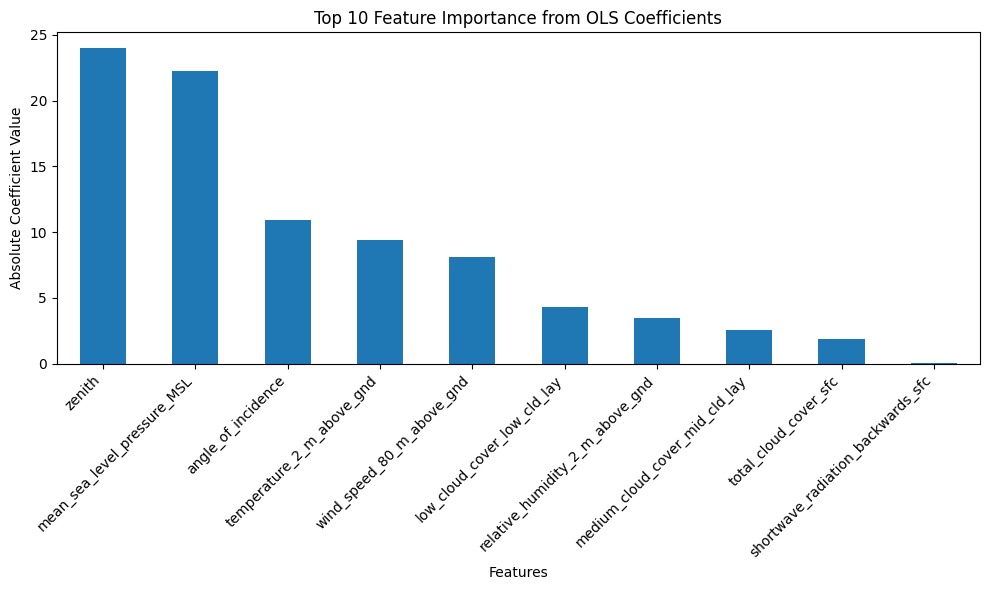

In [9]:
# Step 7: Interpretation
# Feature importance from OLS coeffs
print('Top Features:', model_ols.params.abs().sort_values(ascending=False).head(10))

# Plotting feature importance
feature_importance = model_ols.params.abs().sort_values(ascending=False).drop('const') # Exclude constant for plotting

plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importance from OLS Coefficients')
plt.ylabel('Absolute Coefficient Value')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# SDG: Predictions optimize solar in rural Nepal, reducing fossil reliance.